<a href="https://colab.research.google.com/github/nikishkaaa/ML-Course/blob/main/%22HW_NLP_Classification_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [1]:
!pip install opendatasets --upgrade --quiet

In [167]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import opendatasets as od
import os
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import PunktSentenceTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
import re
import string
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
dataset_url = "https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv"
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: darianikishkina
Your Kaggle Key: ··········


100%|██████████| 1.39M/1.39M [00:00<00:00, 49.9MB/s]


Extracting archive ./tweet-sentiment-extraction/tweet-sentiment-extraction.zip to ./tweet-sentiment-extraction


In [5]:
data_dir = './tweet-sentiment-extraction'
os.listdir(data_dir)

['test.csv', 'train.csv', 'sample_submission.csv']

In [6]:
df = pd.read_csv("./tweet-sentiment-extraction/train.csv")
df.head(5)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [8]:
df.shape

(27481, 4)

In [9]:
 df.isna().sum()

,0
textID,0
text,1
selected_text,1
sentiment,0


In [10]:
df = df[df['text'].notna()]

### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



In [11]:
df['sentiment'].value_counts()

,count
sentiment,
neutral,11117
positive,8582
negative,7781


<Axes: xlabel='sentiment', ylabel='count'>

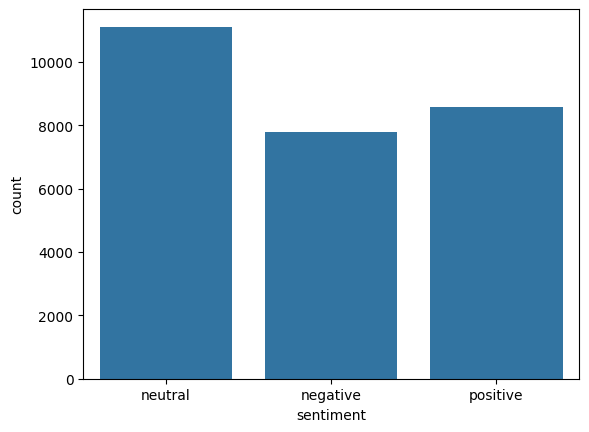

In [12]:
sns.countplot(x ='sentiment', data = df)

<Axes: >

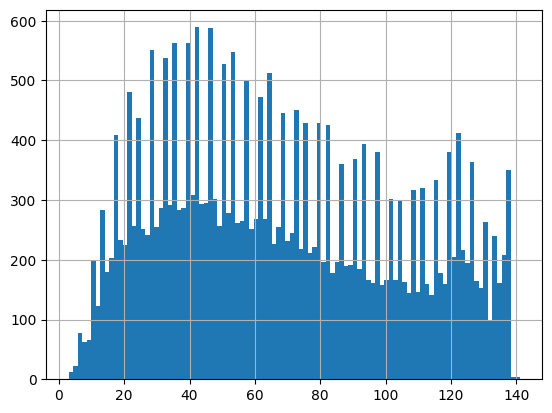

In [13]:
df['post_len'] = df['text'].apply(len)

df.post_len.hist(bins=100)

Висновок:
1. Класи:  розподіл класів нерівномірний, neutral - найбільше. Negative i positive - майже однаково.
2. Довжина постів: розподіл нерівномірний. Основна частина постів від 20 до 80 символів

### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




#### Removing chars

In [14]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [15]:
df['text'] = df['text'].apply(lambda x:clean_text(x))
df['selected_text'] = df['selected_text'].apply(lambda x:clean_text(x))

#### Stop words removing

In [16]:
english_stopwords = stopwords.words('english')

In [17]:
def remove_stop_words(text):
  return [word for word in tokens if word.lower() not in english_stopwords]

#### Tokenizer + Stemper

In [18]:
stemmer = SnowballStemmer(language='english')
def tokenize(text):
    return [stemmer.stem(word) for word in word_tokenize(text)]

#### CountVectorizer

In [19]:
vectorizer = CountVectorizer(lowercase=True,
                             tokenizer=tokenize,
                             stop_words=english_stopwords)

In [20]:
vectorizer.fit(df.text)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function tokenize at 0x787f0c57cc10>)

In [21]:
num_tokens = len(vectorizer.vocabulary_)
print("Tokens:", num_tokens)

Tokens: 21386


#### Adding new stop words based on warning

In [22]:
new_stop_words =  ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv']
combined_stop_words = english_stopwords + new_stop_words

In [23]:
vectorizer = CountVectorizer(lowercase=True,
                             tokenizer=tokenize,
                             stop_words=combined_stop_words,
                             max_df = 15000,
                             min_df= 2)

In [24]:
vectorizer.fit(df.text)

CountVectorizer(max_df=15000, min_df=2,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function tokenize at 0x787f0c57cc10>)

In [25]:
num_tokens = len(vectorizer.vocabulary_)
print("Tokens:", num_tokens)

Tokens: 7828


#### Пошук оптимального значення для max_features

In [26]:
from sklearn.model_selection import KFold

max_features_list = [100, 500, 1000, 2000, None]

cv = KFold(n_splits=5)
results = {}

for max_features in max_features_list:
    feature_counts = []
    for train_index, test_index in cv.split(df.text):
        X_train, X_test = np.array(df.text)[train_index], np.array(df.text)[test_index]

        vectorizer = CountVectorizer(lowercase=True,
                                      tokenizer=tokenize,
                                      stop_words=combined_stop_words,
                                       max_df = 15000,
                                      min_df= 2,
                                      max_features=max_features)
        vectorizer.fit(X_train)

        num_tokens = len(vectorizer.vocabulary_)
        feature_counts.append(num_tokens)

    results[max_features] = np.mean(feature_counts)

for max_features, avg_tokens in results.items():
    print(f"max_features: {max_features}, AVG count of tokens: {avg_tokens}")


max_features: 100, AVG count of tokens: 100.0
max_features: 500, AVG count of tokens: 500.0
max_features: 1000, AVG count of tokens: 1000.0
max_features: 2000, AVG count of tokens: 2000.0
max_features: None, AVG count of tokens: 6823.6


Висновок: найоптимальніший параметр для max_features = 1000.

In [82]:
vectorizer = CountVectorizer(lowercase=True,
                             tokenizer=tokenize,
                             stop_words=combined_stop_words,
                             max_df = 10000,
                             min_df= 2,
                             max_features=1000)
vectorizer.fit(df.text)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CountVectorizer(max_df=10000, max_features=1000, min_df=2,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function tokenize at 0x787f0c57cc10>)

In [83]:
inputs = vectorizer.transform(df.text)

In [84]:
inputs.shape

(27480, 1000)

### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [137]:
X_train_bow, X_test_bow, y_train, y_test = train_test_split(inputs, df.sentiment, random_state=42, test_size=0.3, stratify=df.sentiment)

#### Logistic regression

In [139]:
log_reg =  LogisticRegression(solver = 'sag', max_iter=1000)
log_reg.fit(X_train_bow, y_train)
log_train_preds = log_reg.predict(X_train_bow)

In [140]:
log_train_preds

array(['neutral', 'neutral', 'negative', ..., 'neutral', 'positive',
       'neutral'], dtype=object)

In [141]:
proba = log_reg.predict_proba(X_train_bow)
proba

array([[0.0954517 , 0.81461914, 0.08992916],
       [0.18412942, 0.56595649, 0.24991409],
       [0.96620114, 0.02539194, 0.00840692],
       ...,
       [0.22085655, 0.67816283, 0.10098062],
       [0.09811338, 0.23179998, 0.67008665],
       [0.28710504, 0.56581669, 0.14707827]])

In [142]:
log_test_preds = log_reg.predict(X_test_bow)

In [143]:
print("Train log reg f1-score = ", f1_score(y_train, log_train_preds, average='micro'))
print("Test log reg f1-score = ", f1_score(y_test, log_test_preds, average='micro'))

Train log reg f1-score =  0.7393948845913911
Test log reg f1-score =  0.6855895196506551


#### Desicion Tree

In [144]:
clf = DecisionTreeClassifier(random_state=42, max_depth=55, criterion="entropy", min_samples_split=100)
clf.fit(X_train_bow, y_train)

clf_train_preds = clf.predict(X_train_bow)
clf_test_preds = clf.predict(X_test_bow)


print("Train Decision Tree f1-score = ", f1_score(y_train, clf_train_preds, average='micro'))
print("Test Desicion Tree f1-score = ", f1_score(y_test, clf_test_preds, average='micro'))


Train Decision Tree f1-score =  0.7242669993761697
Test Desicion Tree f1-score =  0.6552644347404173


#### XGBoost

In [147]:
y_train.unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [150]:
category_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
y_train = y_train.replace(category_mapping)
##y_train = y_train.map(category_mapping)
y_test = y_test.replace(category_mapping)

In [159]:
xgb_clf = XGBClassifier(
    max_depth=10,
    n_estimators=200,
    enable_categorical=True,  # для категорійних ознак
    use_label_encoder=False,  # щоб уникнути попереджень, якщо використовуєте нові версії XGBoost
    missing=np.nan,  # явне вказування пропущених значень
    device='cuda'
)

xgb_clf.fit(X_train_bow, y_train)

xgb_train_preds = xgb_clf.predict(X_train_bow)
xgb_test_preds = xgb_clf.predict(X_test_bow)

print("Train XGBoost f1-score = ", f1_score(y_train, xgb_train_preds, average='micro'))
print("Test XGBoost f1-score = ", f1_score(y_test, xgb_test_preds, average='micro'))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:15:50] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:15:50] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:15:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Train XGBoost f1-score =  0.8235599916822625
Test XGBoost f1-score =  0.6940805434255216


Висновок: найкращий результат, як на тренувальних, так і на тестових данних дала модель XGBoost

### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


In [164]:
feature_importance = pd.Series(xgb_clf.feature_importances_, index=vectorizer.get_feature_names_out(), name='imp').sort_values(ascending=False)
feature_importance.head(10)

,imp
thank,0.012252
happi,0.011623
hate,0.010101
sad,0.008299
awesom,0.008183
bore,0.007811
excit,0.007583
suck,0.007577
nice,0.007525
amaz,0.007402


In [165]:
last_features = feature_importance.sort_values(ascending=True)
last_features.head(10)

,imp
record,0.0
front,0.0
cos,0.0
quick,0.0
street,0.0
young,0.0
quiet,0.0
youv,0.0
radio,0.0
memori,0.0


Висновок: модель добре визначає слова, які мають найбільший і найменший вплив на результат класифікації, так як такі слова як thank, happi, hate, sad, awesom тощо логічно показують настрій коментаря, а це і є таргет колонка для передбачення

### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [173]:
vectorizer_tfidf = TfidfVectorizer(lowercase=True,
                             tokenizer=tokenize,
                             stop_words=combined_stop_words,
                             max_df = 10000,
                             min_df= 2,
                             max_features=1000)

In [175]:
inputs_tfidf = vectorizer_tfidf.fit_transform(df.text)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [176]:
X_train, X_test, y_train, y_test = train_test_split(inputs_tfidf, df.sentiment, random_state=42, test_size=0.3, stratify=df.sentiment)

In [179]:
category_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
y_train = y_train.replace(category_mapping)
y_test = y_test.replace(category_mapping)

In [180]:
xgb_clf.fit(X_train, y_train)

xgb_train_preds = xgb_clf.predict(X_train)
xgb_test_preds = xgb_clf.predict(X_test)

print("Train XGBoost f1-score = ", f1_score(y_train, xgb_train_preds, average='micro'))
print("Test XGBoost f1-score = ", f1_score(y_test, xgb_test_preds, average='micro'))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:14:21] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:14:21] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:14:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Train XGBoost f1-score =  0.8659804533166978
Test XGBoost f1-score =  0.6792819019893256


In [182]:
feature_importance = pd.Series(xgb_clf.feature_importances_, index=vectorizer_tfidf.get_feature_names_out(), name='imp').sort_values(ascending=False)
feature_importance.head(10)

,imp
happi,0.010993
sad,0.009190
thank,0.009089
hate,0.007648
suck,0.006644
hurt,0.006487
nice,0.006476
awesom,0.006419
sick,0.005722
ugh,0.005663


Висновок: якість класифікації з TF-IDF стала краще на тестових данних, а от на тестувальних трохи гірша. Найважливіші токени для обох методів майже однакові, але фінальною версією я б обрала саме Bags of Worlds оскільки вона краще перформить на нових данних.

### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

In [208]:
df['predictions'] = xgb_clf.predict(inputs_tfidf)
category_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}
df = df.replace(category_mapping)
df

,textID,text,selected_text,sentiment,post_len,predictions,proba,prediction_0.2
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,36,neutral,0.163928,False
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,46,negative,0.980708,True
2,088c60f138,my boss is bullying me,bullying me,negative,25,neutral,0.211509,False
3,9642c003ef,what interview leave me alone,leave me alone,negative,31,neutral,0.161837,False
4,358bd9e861,sons of why couldnt they put them on the rel...,sons of,negative,75,negative,0.653790,True
...,...,...,...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on denver husband l...,d lost,negative,77,negative,0.871877,True
27477,4f4c4fc327,ive wondered about rake to the client has ma...,dont force,negative,122,neutral,0.335050,True
27478,f67aae2310,yay good for both of you enjoy the break you...,yay good for both of you,positive,111,positive,0.004252,False
27479,ed167662a5,but it was worth it,but it was worth it,positive,27,positive,0.189836,False


In [209]:
df[df['predictions'] != df['sentiment']]

,textID,text,selected_text,sentiment,post_len,predictions,proba,prediction_0.2
2,088c60f138,my boss is bullying me,bullying me,negative,25,neutral,0.211509,False
3,9642c003ef,what interview leave me alone,leave me alone,negative,31,neutral,0.161837,False
5,28b57f3990,some shameless plugging for the best rangers...,some shameless plugging for the best rangers...,neutral,92,positive,0.122821,False
12,74a76f6e0a,my sharpie is running dangerously low on ink,dangerously,negative,44,neutral,0.202870,False
15,8a939bfb59,uh oh i am sunburned,uh oh i am sunburned,negative,21,neutral,0.328013,True
...,...,...,...,...,...,...,...,...
27439,ecfc3c4122,i am beginning to think sun blcok is a haox,haox,negative,44,neutral,0.216352,False
27455,768e382964,simple greetings from unexpected people can ac...,simple greetings from unexpected people can ac...,positive,101,neutral,0.258014,False
27466,7e8b34de71,naw it was pretty tame only guy in costume a...,naw it was pretty tame only guy in costume a ...,neutral,129,negative,0.510529,True
27471,15bb120f57,im defying gravity and nobody in alll of oz no...,im defying gravity and nobody in alll of oz no...,neutral,106,negative,0.605242,True


In [210]:
df['proba'] =  xgb_clf.predict_proba(inputs_tfidf)
df[df['predictions'] != df['sentiment']]

,textID,text,selected_text,sentiment,post_len,predictions,proba,prediction_0.2
2,088c60f138,my boss is bullying me,bullying me,negative,25,neutral,0.211509,False
3,9642c003ef,what interview leave me alone,leave me alone,negative,31,neutral,0.161837,False
5,28b57f3990,some shameless plugging for the best rangers...,some shameless plugging for the best rangers...,neutral,92,positive,0.122821,False
12,74a76f6e0a,my sharpie is running dangerously low on ink,dangerously,negative,44,neutral,0.202870,False
15,8a939bfb59,uh oh i am sunburned,uh oh i am sunburned,negative,21,neutral,0.328013,True
...,...,...,...,...,...,...,...,...
27439,ecfc3c4122,i am beginning to think sun blcok is a haox,haox,negative,44,neutral,0.216352,False
27455,768e382964,simple greetings from unexpected people can ac...,simple greetings from unexpected people can ac...,positive,101,neutral,0.258014,False
27466,7e8b34de71,naw it was pretty tame only guy in costume a...,naw it was pretty tame only guy in costume a ...,neutral,129,negative,0.510529,True
27471,15bb120f57,im defying gravity and nobody in alll of oz no...,im defying gravity and nobody in alll of oz no...,neutral,106,negative,0.605242,True


In [211]:
 df[(df['predictions'] != df['sentiment']) & (df['sentiment'] == 'positive')]

,textID,text,selected_text,sentiment,post_len,predictions,proba,prediction_0.2
30,d33f811375,im going home now have you seen my new twitter...,quiteheavenly,positive,84,neutral,0.197221,False
68,fa2654e730,chilliin,chilliin,positive,8,neutral,0.211509,False
81,58d382e07a,lucky kidi so wanna see loserville pity im i...,lucky,positive,57,neutral,0.090712,False
108,561b44a42f,have a safe trip joshy pooyoull knock them de...,safe,positive,71,neutral,0.312708,True
117,9843c4688e,hahaa your awesomee,hahaa your awesomee,positive,22,neutral,0.211509,False
...,...,...,...,...,...,...,...,...
27400,3c5450835e,i still have them yay gonna eat some now,yay,positive,44,neutral,0.071143,False
27401,261e064dd4,oh silence verona i am wanting to go jaja ...,ja enjoyyitverymu,positive,107,neutral,0.179184,False
27407,04db7e701e,really really wants to go and see coraline,really really wants to go and see coraline,positive,43,neutral,0.236967,False
27417,2151413f96,ish okay my loveee,ish okay my loveee,positive,18,neutral,0.165556,False


In [212]:
df[(df['predictions'] != df['sentiment']) & (df['sentiment'] == 'neutral')]

,textID,text,selected_text,sentiment,post_len,predictions,proba,prediction_0.2
5,28b57f3990,some shameless plugging for the best rangers...,some shameless plugging for the best rangers...,neutral,92,positive,0.122821,False
24,0c8cc71c46,see wat i mean bout friidays its called lose ...,see wat i mean bout friidays its called lose ...,neutral,79,negative,0.587602,True
34,d21ab5855b,ahhh i slept through the game im gonna try m...,ahhh i slept through the game im gonna try my...,neutral,102,positive,0.105491,False
50,a3ae670885,then you should check out and connect with o...,then you should check out and connect with ot...,neutral,98,negative,0.760363,True
51,15d5f3a41b,also bored at school its my third freelesson ...,also bored at school its my third freelesson f...,neutral,60,negative,0.690897,True
...,...,...,...,...,...,...,...,...
27363,a232d645c7,stu lantz is awesome i miss chick hearn tho,stu lantz is awesome i miss chick hearn tho,neutral,45,negative,0.426354,True
27375,755b099d60,happy did crepe again,happy did crepe again,neutral,24,positive,0.312813,True
27382,d9f2cebb13,happy sammy is going here but unfortunatly i...,happy sammy is going here but unfortunatly i...,neutral,107,positive,0.082906,False
27466,7e8b34de71,naw it was pretty tame only guy in costume a...,naw it was pretty tame only guy in costume a ...,neutral,129,negative,0.510529,True


In [213]:
df[(df['predictions'] != df['sentiment']) & (df['sentiment'] == 'negative')]

,textID,text,selected_text,sentiment,post_len,predictions,proba,prediction_0.2
2,088c60f138,my boss is bullying me,bullying me,negative,25,neutral,0.211509,False
3,9642c003ef,what interview leave me alone,leave me alone,negative,31,neutral,0.161837,False
12,74a76f6e0a,my sharpie is running dangerously low on ink,dangerously,negative,44,neutral,0.202870,False
15,8a939bfb59,uh oh i am sunburned,uh oh i am sunburned,negative,21,neutral,0.328013,True
16,3440297f8b,sok trying to plot alternatives as we speak sigh,sigh,negative,53,neutral,0.410999,True
...,...,...,...,...,...,...,...,...
27427,413195db27,is wondering what happened to the sun may grey,,negative,53,neutral,0.309508,True
27436,c834d840d2,hi all i have daughters and my youngest turn...,sniffle sniffle sob sob,negative,117,neutral,0.208368,False
27438,9057950ae4,where is my bestie when i need him,where is my bestie when i need him,negative,35,neutral,0.211509,False
27439,ecfc3c4122,i am beginning to think sun blcok is a haox,haox,negative,44,neutral,0.216352,False


<Axes: >

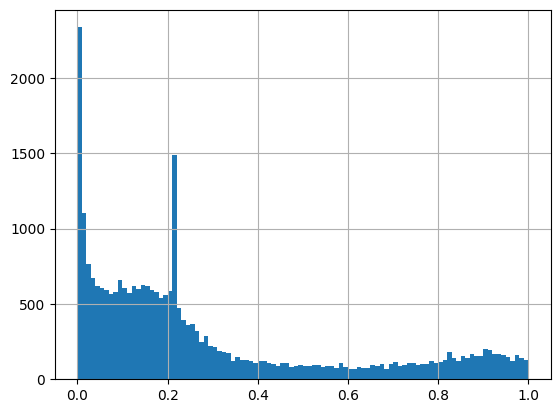

In [190]:
df.proba.hist(bins=100)

Висновок: TF-IDF найбільше помиляється на екземлярах negative, через те, що не надає ваги словам, які "маркерують" такі документи. Для покращення якості TF-IDF я би збалансувала класи, замість стемінгу застосувала лематизацію, щоб модель більш точно надавла ваги для слів

І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model